# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [2]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

## Load files

In [15]:
dirpath = Path(settings_dict['save_dir'])


In [78]:
nodefiles = get_cell_filepaths(dirpath)

In [88]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [89]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

In [90]:
df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

In [109]:
if syn == 'pre-synaptic':
    df_syn.drop(df_syn[df_syn['pre'].isin([299392199,386392158,472361842,389085521,227254070,228321391,403522169,313068329,126649726])].index, inplace=True)

In [183]:
# df_syn.loc[df_syn['pre']==285761792,'pre_type']='pe'

## Cell types dict

In [91]:
cell_types = {}

for i,r in df_syn.iterrows():
    cell_types[r['pre']]=r['pre_type'].lower()
    cell_types[r['post']]=r['post_type'].lower()
    


## Cell features to add

### Soma diameter

In [58]:
cells_in_synmat = set(df_syn['pre'].unique())|set(df_syn['post'].unique())

soma_diam = {}
soma_loc = {}
for x in cells_in_synmat:
    cell = ecrest(settings_dict,filepath = nodefiles[str(x)],launch_viewer=False)
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']

        if len(soma_anno)==4:
            xpts = [p[0] for p in soma_anno]
            ypts = [p[1] for p in soma_anno]
            zpts = [p[2] for p in soma_anno]
            
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])/1000
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)])/1000,np.mean(ypts)/1000,np.mean([np.max(zpts),np.min(zpts)])/1000)
            
        if len(soma_anno)!=4:
            soma_diam[x] = np.NaN
            soma_loc[x] = np.NaN
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN
        soma_loc[x] = np.NaN


In [ ]:
soma_diam[127672247]

#### distribution soma diam

In [59]:
df = pd.DataFrame(soma_diam.items(), columns=['cell', 'soma diam']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_types[c]

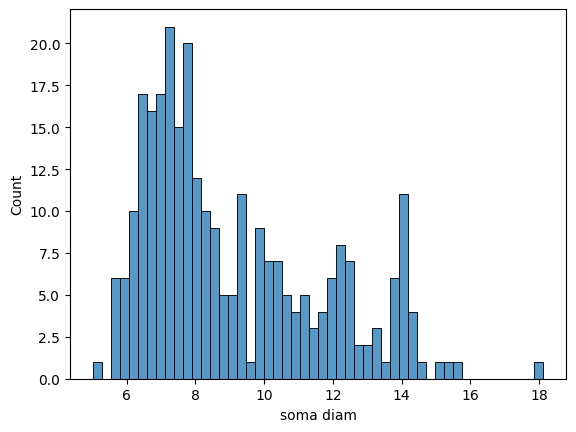

In [60]:
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2'])],x='soma diam',bins = 50)#,hue='type')

<AxesSubplot:xlabel='soma diam', ylabel='Density'>

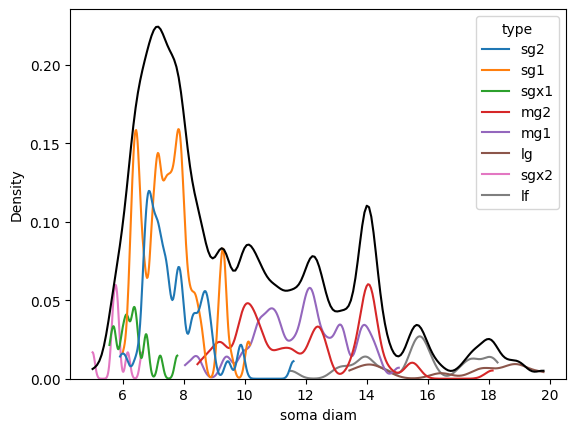

In [61]:

hfig,ax = plt.subplots(1)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,hue='type',ax=ax)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,color='black',ax=ax)

#### Load into df_syn

In [9]:

for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_diam']=soma_diam[df_syn.loc[i,'pre']]
        df_syn.loc[i,'post_diam']=soma_diam[df_syn.loc[i,'post']]
    except:
        continue
df_syn.loc[:,'diam_diff'] = (df_syn['post_diam']-df_syn['pre_diam'])/df_syn['pre_diam']


# Completeness of synapses

In [92]:
all_types = set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','soma-diam','n_syn','done','todo','completed'])
for c in df_syn['pre'].unique():
    
    if (df_syn[df_syn['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_syn[df_syn['pre'].isin([c])]

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)

        try:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'type': cell_types[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': len(cell.cell_data['end_points'][syn]),
                'done': len(c_df),
                'todo': len(cell.cell_data['end_points'][syn]) - len(c_df),
                'completed': len(c_df) / (len(cell.cell_data['end_points'][syn]))
                }
        except:
            print(f'error on {c}')
            continue

        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

In [93]:
df_progress[df_progress['type'].isin(['pf'])][['id','n_syn']].sort_values('n_syn')#['id'].values

,id,n_syn
0,283409102,1
0,283409751,1
0,283409598,1
0,282249203,2
0,634858913,2
0,463077884,2
0,369312294,2
0,282249246,3
0,372899977,3
0,297177312,4


In [1042]:
# df_progress[df_progress['type'].isin(['mg1'])].sort_values('todo')

In [12]:
df_progress[df_progress['completed']>0.9][['id','type','completed']].groupby('type').describe()

completed                                                              \
          count      mean       std       min       25%       50%       75%   
type                                                                          
dml         3.0  0.975370  0.031409  0.940000  0.963056  0.986111  0.993056   
grc-d      10.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
grc-s       9.0  0.991597  0.021361  0.935484  1.000000  1.000000  1.000000   
mg1        14.0  0.965866  0.039119  0.902439  0.932321  0.975415  1.000000   
mg2        11.0  0.973491  0.038005  0.905405  0.940972  1.000000  1.000000   
pe          4.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
pf          4.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.000000   
sg1        16.0  0.999381  0.002475  0.990099  1.000000  1.000000  1.000000   
sg2        14.0  0.983364  0.032998  0.907407  0.995787  1.000000  1.000000   
sgx1        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   
sgx2        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.000000   

            
       max  
type        
dml    1.0  
grc-d  1.0  
grc-s  1.0  
mg1    1.0  
mg2    1.0  
pe     1.0  
pf     1.0  
sg1    1.0  
sg2    1.0  
sgx1   1.0  
sgx2   1.0

# Edges

## Filtered df_syn

In [94]:
# Filter by pre and/or post cell type

network_types = (set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique())) - set(['glia'])#,'tsd','dml']) #'tsd','dml','sgx1','sgx2'])
df_syn = df_syn[(df_syn['pre_type'].isin(network_types - set(['sgx1','sgx2'])))&(df_syn['post_type'].isin(network_types))]# - set(['lg','lf'])

In [95]:
df_syn = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[(df_progress['type'].isin(['pf'])) & (df_progress['n_syn']>1)]['id'].values])]

In [44]:
# Filter by completeness of synaptic reconstructions

if syn=='post-synaptic':
    df_syn_completed = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
    df_syn = pd.concat([df_syn_completed,df_syn[df_syn['pre_type'].isin(['aff'])]])
    
    
if syn=='pre-synaptic':
    df_syn = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.3]['id'].values])]


### absolute synapses locations in df_edges

In [66]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088'
}

In [ ]:
for v in ['x','y','z']:
    df_syn[v] = df_syn[v]/1000
    

In [101]:
df_syn['y'] = df_syn['y']*-1

In [23]:
df_syn[df_syn['pre_type'].isin(['pe','pf'])]['pre'].unique()

array([282248367, 282249203, 282249246, 282264725, 283408821, 283408822,
       283408851, 283409058, 290291065, 297177312, 368151099, 368151126,
       372899977, 441321646, 463077884, 634858913, 636004167])

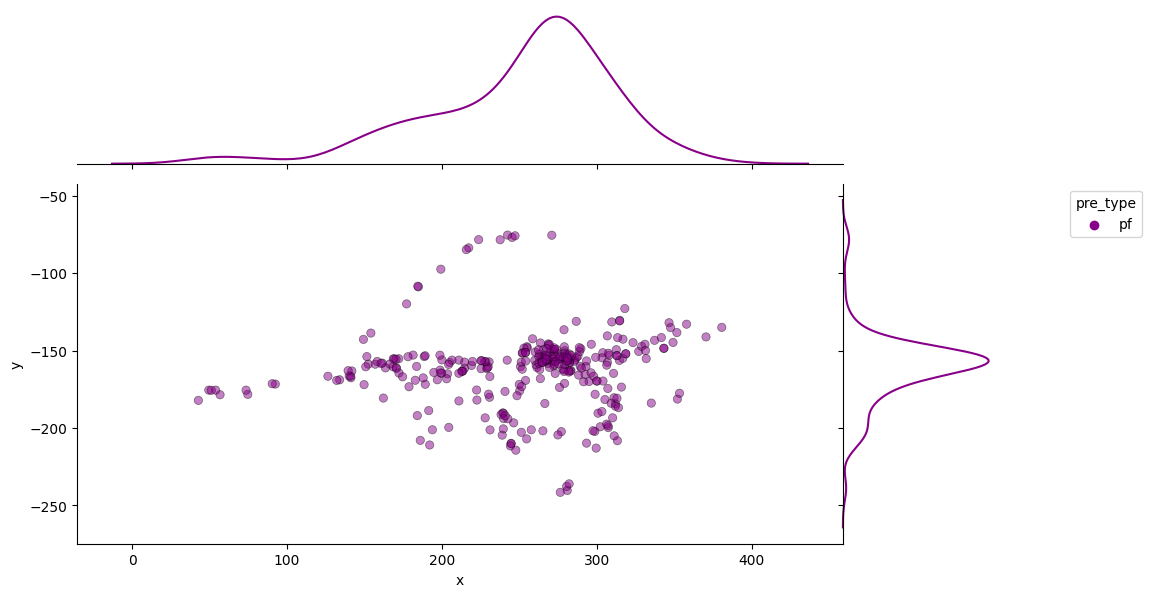

In [102]:

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['pf'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

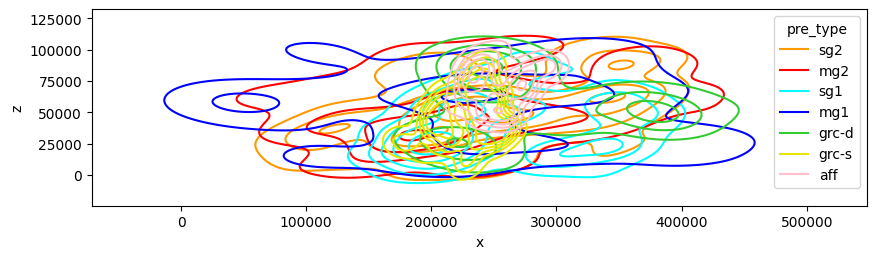

In [240]:
hfig,ax = plt.subplots(1,figsize=(10,10))

g = sns.kdeplot(ax = ax,data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='x',y='z',hue='pre_type',
                common_norm=True,palette=syn_colors,levels=6)#,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
# ax.set_xlim(-100,100)
ax.set_aspect('equal')

# hfig,ax = plt.subplots(3,figsize=(6,6))
# sns.kdeplot(ax=ax[0],data = df_syn_locs,x='x',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[1],data = df_syn_locs,x='y',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[2],data = df_syn_locs,x='z',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# plt.tight_layout()

### synapses locations relative to cell type soma in df_edges

In [81]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

In [151]:
df_syn

,Unnamed: 0,pre,post,structure,x,y,z,pre_type,post_type
0,0,126649726,385405062,axon,332848,246512,18570,mg2,dml
1,1,126649726,385405062,axon,333088,245984,15540,mg2,dml
2,2,128832297,126556393,unknown,274240,254080,23010,sg1,uk
3,3,128832297,223864713,axon,276320,255008,22740,sg1,grc-d
4,4,128832297,127702707,unknown,277056,254880,22350,sg1,uk
...,...,...,...,...,...,...,...,...,...
3094,3094,565013265,567318720,unknown,248288,320944,82980,grc-s,uk
3095,3095,565013265,482512968,unknown,215792,327648,78300,grc-s,uk
3096,3096,565013265,568432342,axon,234322,303139,84885,grc-s,grc-d
3097,3097,565013265,399018592,axon,253119,306716,78705,grc-s,grc-d


In [1856]:
df_loc = pd.DataFrame(soma_loc.items(), columns=['cell', 'soma loc']).set_index('cell')
post_types_subset = ['lf','lg']

for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

# df_to_plot = df_loc[(df_loc.index.isin(df_progress[df_progress['completed']>0.9]['id'].values))&df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()
df_to_plot = df_loc[df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()

# Initialize an empty DataFrame
df_syn_locs = pd.DataFrame(columns=['x', 'y', 'z', 'cell_type'])

# Loop through cell types and extend the DataFrame
for i,r in df_to_plot.iterrows():
    # print(i,r)
    
    x,y,z = r['soma loc']
    cell = df_syn[(df_syn['pre'].isin([int(i)])) & (df_syn['post_type'].isin(post_types_subset))]
    # cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    positions = [(s[0]/1000-x,s[1]/1000-y,s[2]/1000-z) for s in list(cell[['x','y','z']].to_records(index=False))]#cell.cell_data['end_points']['post-synaptic']]
   
    # break
    cell_df = pd.DataFrame(positions, columns=['x', 'y', 'z'])  # Create DataFrame for the current cell type
    cell_df['cell_type'] = r['type']  # Add cell type column
    df_syn_locs = pd.concat([df_syn_locs, cell_df], ignore_index=True)  # Concatenate the current cell DataFrame to the main DataFrame

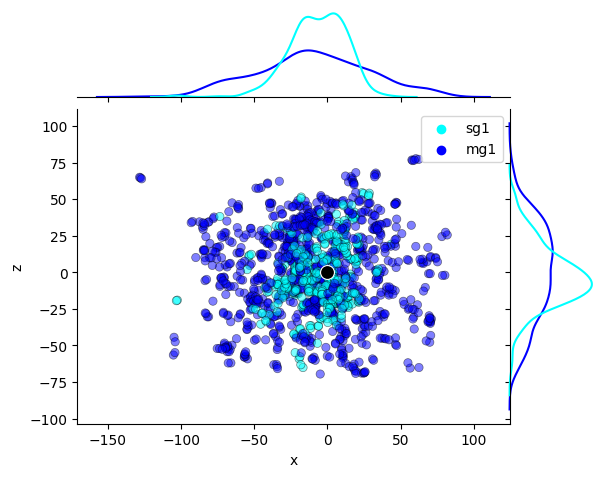

In [1850]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

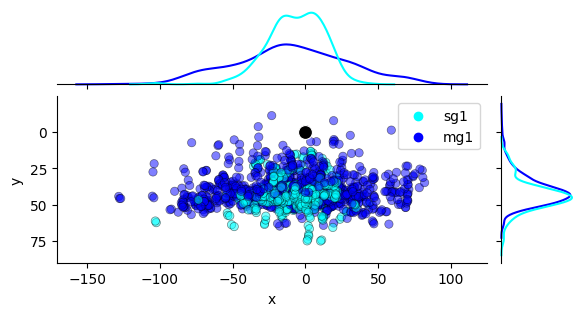

In [1857]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

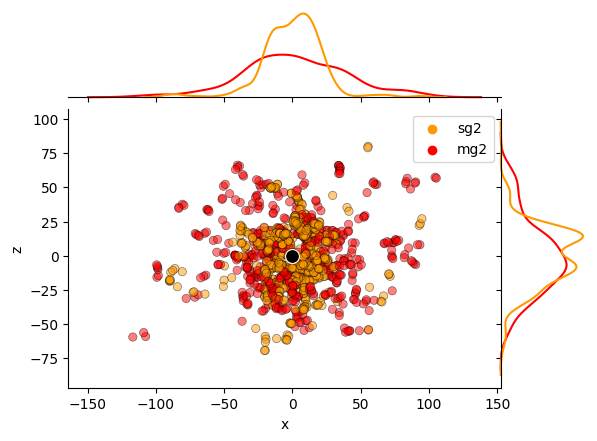

In [1806]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

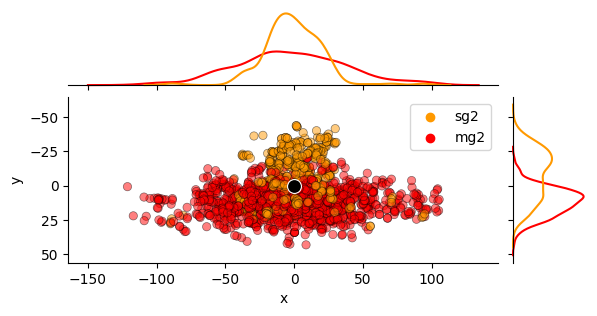

In [1858]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

In [ ]:
g.ax_joint.set_aspect('equal')

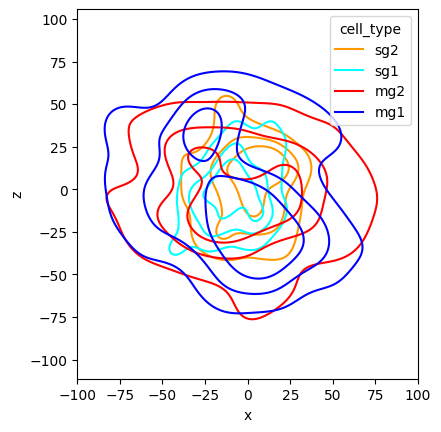

In [1853]:
# hfig,ax = plt.subplots(1,figsize=(3,6))
g = sns.kdeplot(data = df_syn_locs,x='x',y='z',hue='cell_type',common_norm=False,palette=syn_colors,levels=4,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
ax.set_xlim(-100,100)
ax.set_aspect('equal')

# hfig,ax = plt.subplots(3,figsize=(6,6))
# sns.kdeplot(ax=ax[0],data = df_syn_locs,x='x',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[1],data = df_syn_locs,x='y',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[2],data = df_syn_locs,x='z',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# plt.tight_layout()

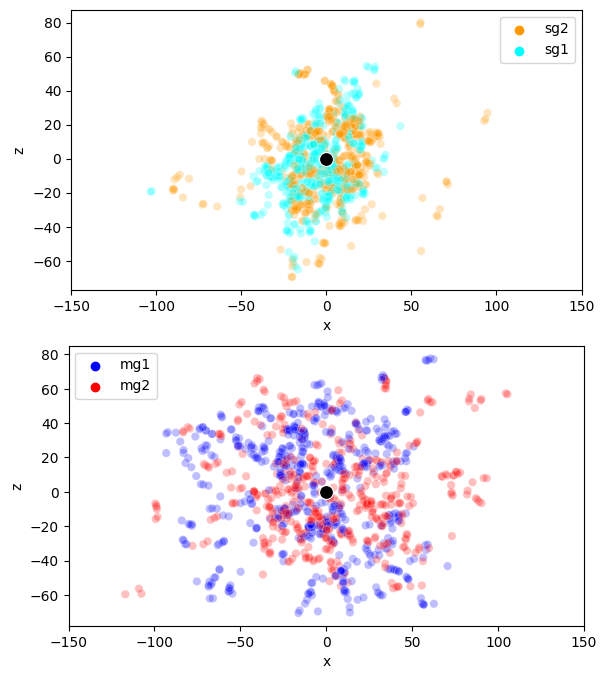

In [1576]:
hfig,ax = plt.subplots(2,figsize=(10,8))
sns.scatterplot(ax=ax[0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','sg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[0],x=[0],y=[0],color='black',s=100)
sns.scatterplot(ax=ax[1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1','mg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[1],x=[0],y=[0],color='black',s=100)
for a in ax:
    a.set_xlim(-150,150)
    # a.set_ylim(-3000,3000)
    a.set_aspect('equal')

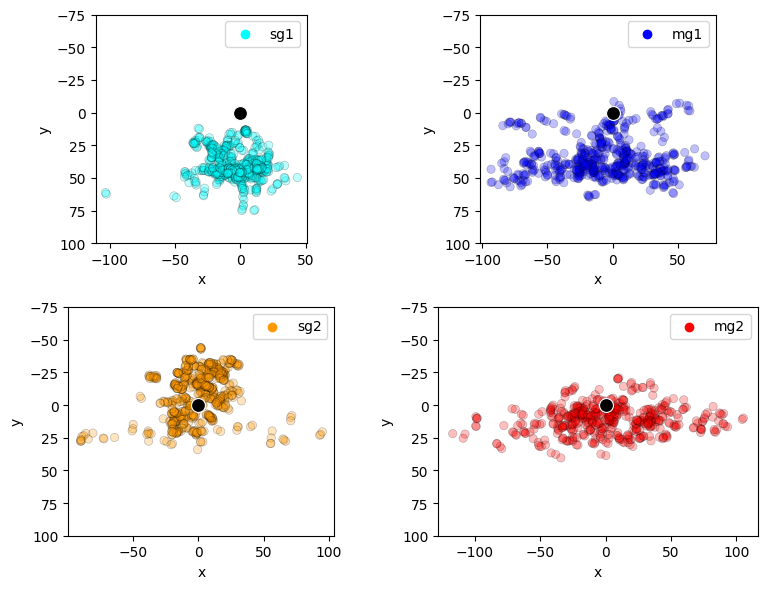

In [1582]:
hfig,ax = plt.subplots(2,2,figsize=(8,6))
sns.scatterplot(ax=ax[0,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[0,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
for a in ax:
    for a2 in a:
        sns.scatterplot(ax=a2,x=[0],y=[0],color='black',s=100)

for a in ax:
    for a2 in a:
        # a2.set_xlim(-200,200)
        a2.set_ylim(-75,100)
        a2.set_aspect('equal')
        a2.invert_yaxis()

plt.tight_layout()


## shuffle synaptic connection dataframe

In [ ]:
df1 = df_syn.sample(frac = 1).reset_index()
display(df1)

df_syn.loc[df1['index'],['post']] = df1['post']
df_syn.loc[df1['index'],['post_type']] = df1['post_type']

## df_syn --> df_edges

In [221]:
df_syn

,pre,post,pre_type,post_type,pre_diam,post_diam,diam_diff
37,127672247,647640784,sg2,lg,9.847,NaN,NaN
38,127672247,647640784,sg2,lg,9.847,NaN,NaN
39,127672247,472392041,sg2,lg,9.847,NaN,NaN
40,127672247,472392041,sg2,lg,9.847,NaN,NaN
41,127672247,472392041,sg2,lg,9.847,NaN,NaN
...,...,...,...,...,...,...,...
9302,61319896,484881347,aff,grc-d,NaN,NaN,NaN
9303,61319896,481520358,aff,grc-d,NaN,NaN,NaN
9304,61319896,310839225,aff,grc-d,NaN,6.119,NaN
9305,61319896,483704550,aff,grc-d,NaN,NaN,NaN


In [103]:
# remove structure and soma diameter information if want to

df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [104]:
df_edges=df_syn.value_counts().reset_index(name='weight')

In [111]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

# CDF

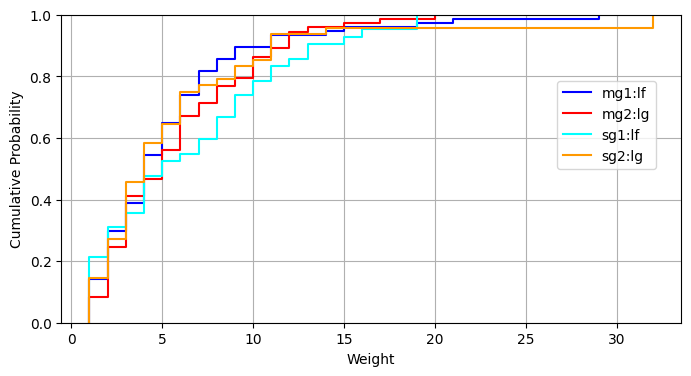

In [227]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1','sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
    if (pre_type in ['mg2','sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

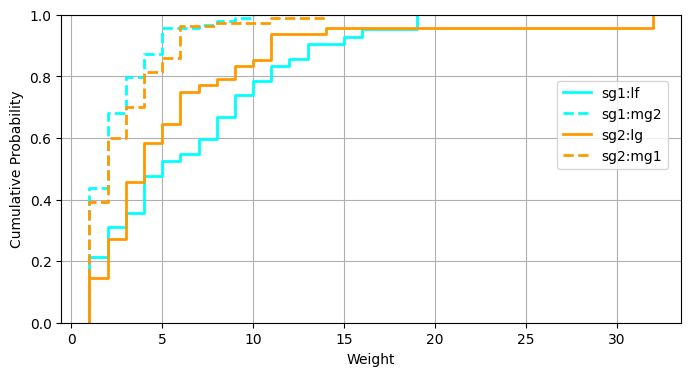

In [228]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['sg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

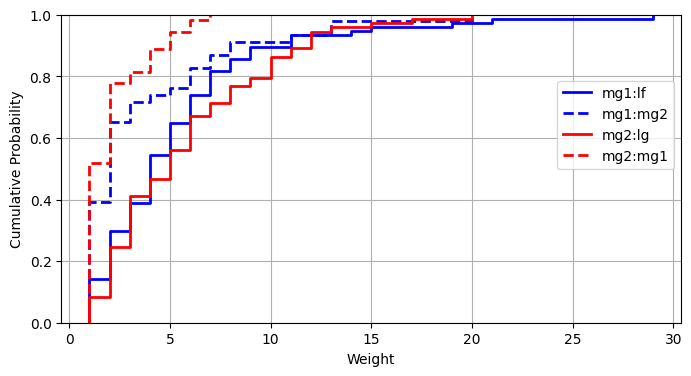

In [229]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['mg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

# Connectivity Matrix quantifications

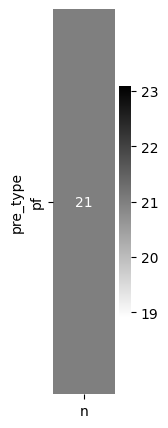

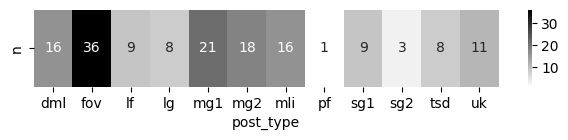

In [45]:
# Calculate the total number of 'pre' nodes for each 'pre_type'
total_pre_nodes = df_edges.groupby('pre_type')['pre'].nunique().reset_index()
total_pre_nodes.loc[:,'number labeled']='n'
total_pre_nodes = total_pre_nodes.pivot(index='pre_type', columns='number labeled', values='pre')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

###
# Calculate the total number of 'post' nodes for each 'post_type'
total_post_nodes = df_edges.groupby('post_type')['post'].nunique().reset_index()
total_post_nodes.loc[:,'number reconstructed']='n'
total_post_nodes = total_post_nodes.pivot(index='number reconstructed', columns='post_type', values='post')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_nodes, annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

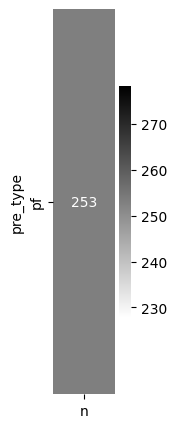

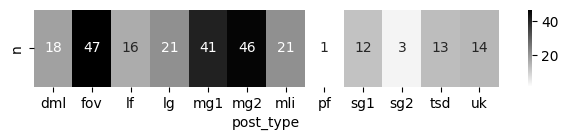

In [47]:
grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

### pre
df_pivot = df_edges.groupby('pre_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_pre_syn = df_pivot.pivot(index='pre_type', columns='n',values='weight')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

### post
df_pivot = df_edges.groupby('post_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_post_syn = df_pivot.pivot(index='n', columns='post_type',values='weight')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

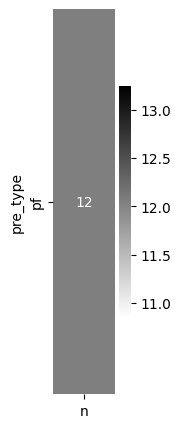

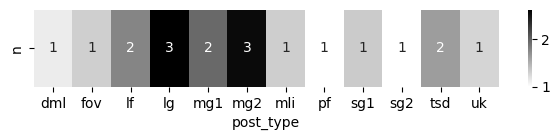

In [48]:
'''mean synapses per cell'''

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn / total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn / total_post_nodes,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

<AxesSubplot:xlabel='post_type', ylabel='pre_type'>

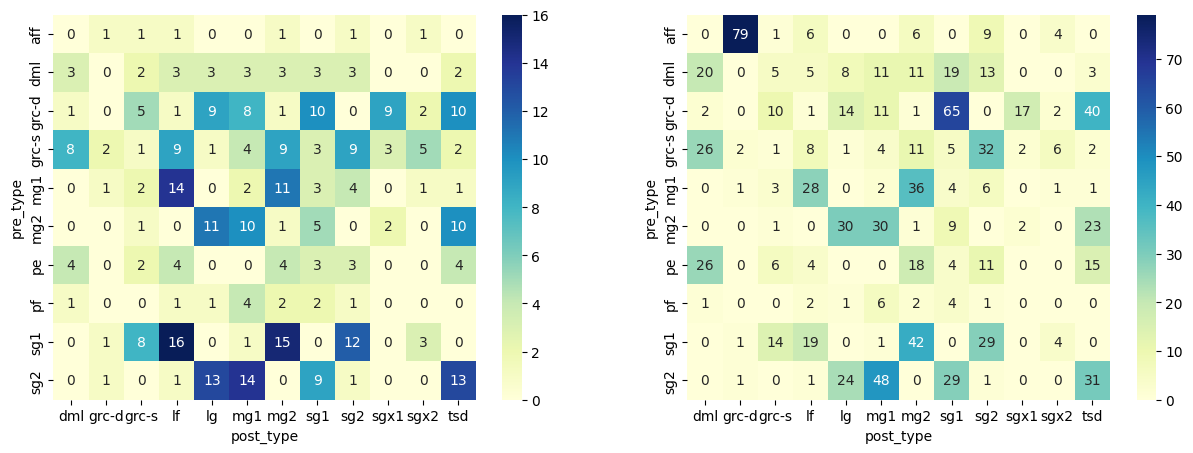

In [50]:
'''
This code does not repeat counting a post cell if more than one pre cell synapses on it
'''
# Calculate the number of 'pre' nodes of each 'pre_type' for each 'post_type'
pre_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().unstack(fill_value=0)

# Calculate the number of 'post' nodes of each 'post_type' for each 'pre_type'
post_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['post'].nunique().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pre_type_contributions, annot=True, cmap="YlGnBu", ax=axes[0])
sns.heatmap(post_type_contributions, annot=True, cmap="YlGnBu", ax=axes[1])

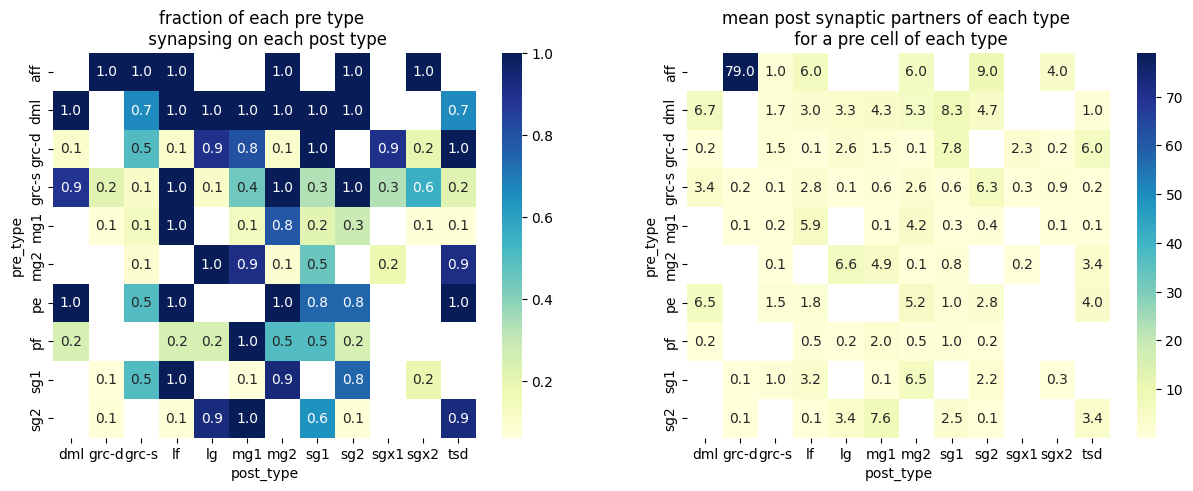

In [51]:
# Calculate the number of edges for each pre-post pair (unique_counts['n_post'])
# Different from the number of unique post nodes
edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
# The following gives the same as "pre_type_contributions" but with more code: unique_counts['n_pre'] = df_edges.groupby(['pre_type', 'post_type'])[['pre','post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['pre'].sum().reset_index().rename(columns={'pre': 'n_pre'})['n_pre']
pre_counts = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().reset_index().rename(columns={'pre': 'n_pre'})
edge_counts['n_pre'] = pre_counts['n_pre']

n_pre_all = [df_edges.groupby(['pre_type'])['pre'].nunique()[p_] for p_ in edge_counts['pre_type']]# unique_counts['pre_type']]

edge_counts['percent_pre'] = edge_counts['n_pre'].div(n_pre_all)
edge_counts['mean_post_count'] = edge_counts['n_post'].div(n_pre_all)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='percent_pre')
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[0])

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='mean_post_count')#.fillna(0)
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[1])#,vmax=10)

axes[0].set_title('fraction of each pre type \n synapsing on each post type')
axes[1].set_title('mean post synaptic partners of each type \n for a pre cell of each type');

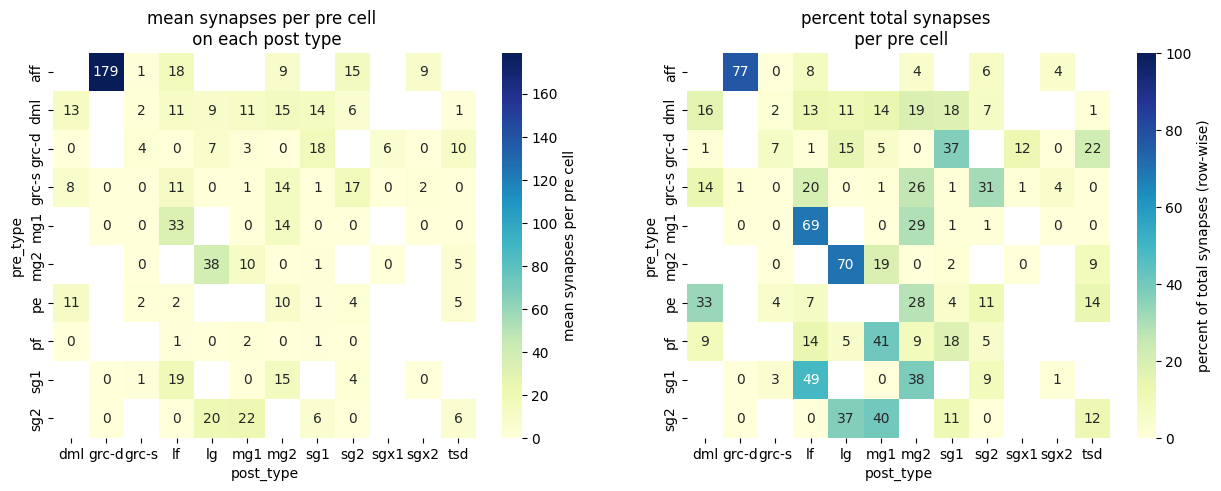

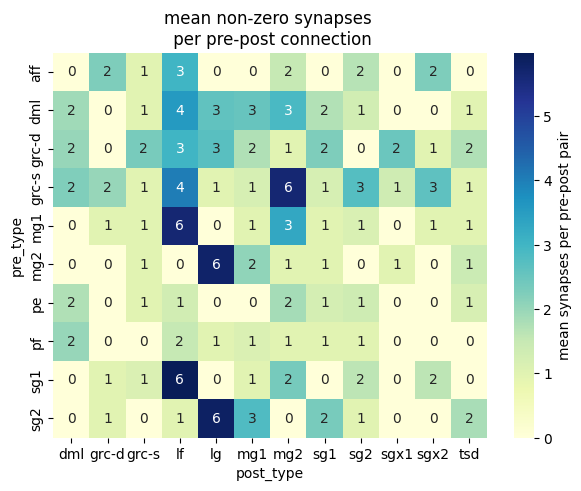

In [52]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = np.round(res.weight / syn_total *100)
res.loc[:,'weight_per_cell'] = res.weight / n_pre
# res.loc[:,'weight_per_pair'] = res.weight / n_post #* does not work because this is div by all npost, not those in that pairing

# hfig,ax = plt.subplots(1,figsize=(5,2))
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_per_cell'),#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes[0], fmt=".0f", #,vmax=100
           cbar_kws={'label': 'mean synapses per pre cell'})

sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm'),#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100,ax=axes[1], #
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

axes[0].set_title('mean synapses per pre cell \n on each post type')
axes[1].set_title('percent total synapses \n per pre cell');


edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
res.loc[:,'n_edges']=edge_counts['n_post'].values
res.loc[:,'u_edges']=res['weight']/res['n_edges']
fig, axes = plt.subplots(1, figsize=(7, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='u_edges').fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes, fmt=".0f",
           cbar_kws={'label': 'mean synapses per pre-post pair'});
axes.set_title('mean non-zero synapses \n per pre-post connection');

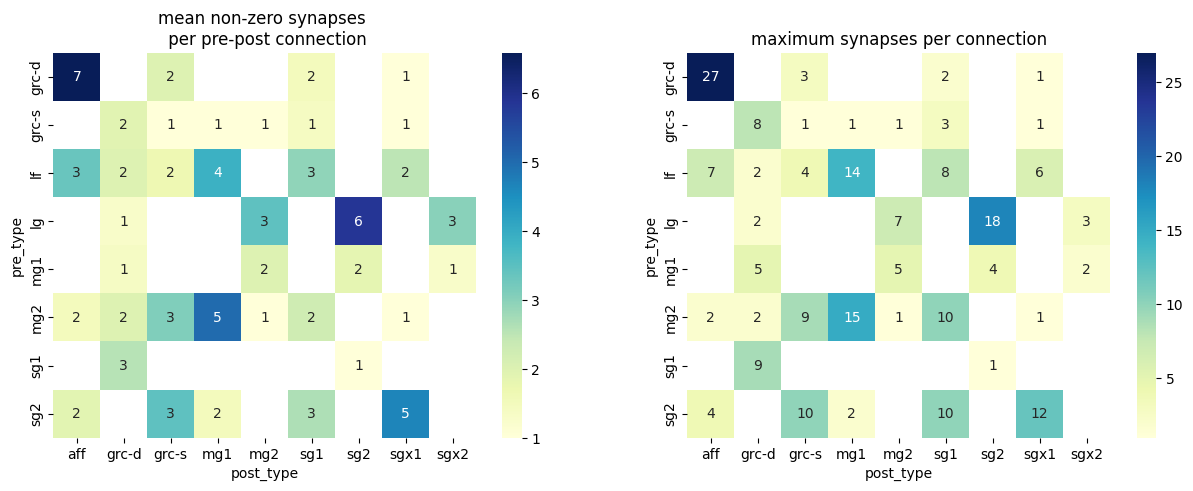

In [123]:

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].agg(['mean', 'min', 'max']).reset_index()

# Pivot the DataFrame to get matrices for median, min, and max weights
mean_matrix = grouped.pivot(index='pre_type', columns='post_type', values='mean')
min_matrix = grouped.pivot(index='pre_type', columns='post_type', values='min')
max_matrix = grouped.pivot(index='pre_type', columns='post_type', values='max')

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('mean non-zero synapses \n per pre-post connection');
# axes[1].set_title('Minimum Connection Weights')
axes[1].set_title('maximum synapses per connection')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(mean_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0])
# sns.heatmap(min_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])
sns.heatmap(max_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])

# plt.tight_layout()
plt.show();

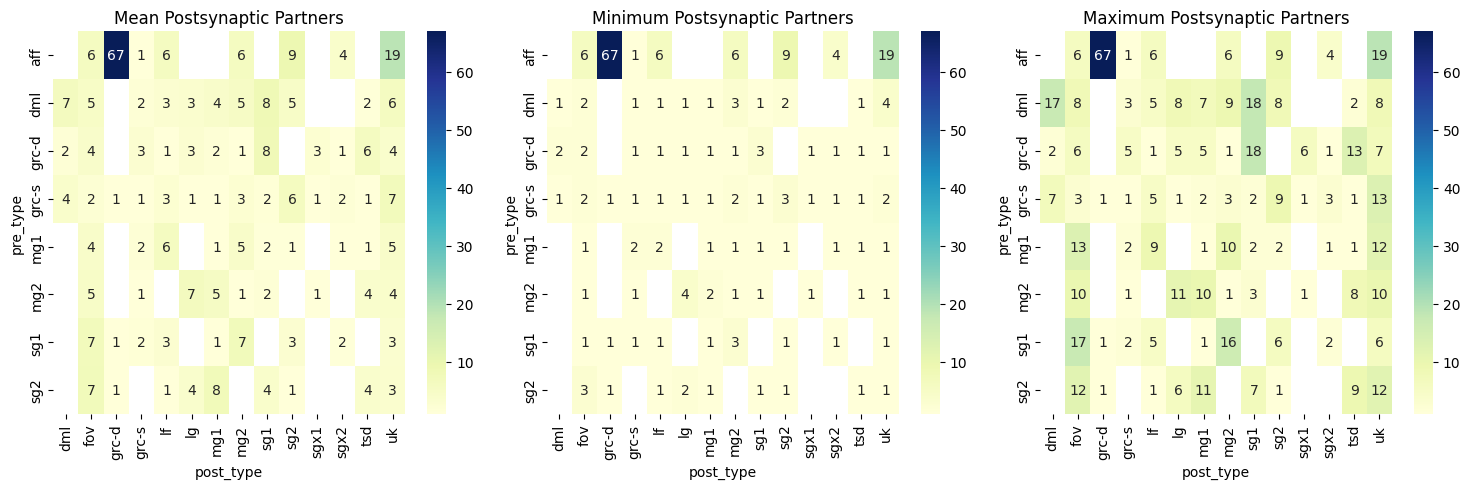

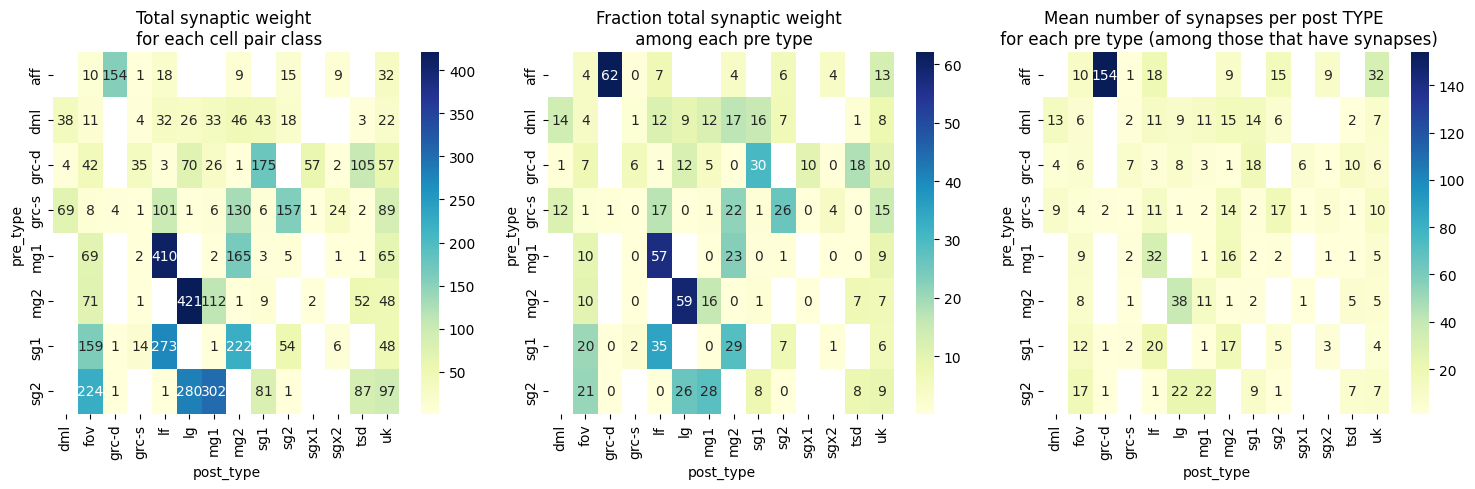

In [26]:
'''
connection partners only among pre cells that synapse on that type
'''

# Calculate the average number of unique 'post' cells for each 'pre_type'
average_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
min_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).min().unstack() # min_counts = min_counts.applymap(lambda x: f'{x:.1f}').astype(float)
max_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).max().unstack() # max_counts = max_counts.applymap(lambda x: f'{x:.1f}').astype(float)

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('Mean Postsynaptic Partners')
axes[1].set_title('Minimum Postsynaptic Partners')
axes[2].set_title('Maximum Postsynaptic Partners')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(average_counts, annot=True, cmap="YlGnBu", ax=axes[0], fmt=".0f")
sns.heatmap(min_counts, annot=True, cmap="YlGnBu", ax=axes[1], fmt=".0f")
sns.heatmap(max_counts, annot=True, cmap="YlGnBu", ax=axes[2], fmt=".0f")

plt.tight_layout()
# plt.show();

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()

# Pivot the DataFrame to get the desired matrix
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(matrix, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])

matrix_normalized = matrix.div(matrix.sum(axis=1), axis=0).div(0.01)
sns.heatmap(matrix_normalized, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

average_weight = df_edges.groupby(['pre_type', 'post_type', 'pre'])['weight'].sum().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
sns.heatmap(average_weight, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[2])

# Set titles for subplots
axes[0].set_title('Total synaptic weight \n for each cell pair class')
axes[1].set_title('Fraction total synaptic weight \n among each pre type')
axes[2].set_title('Mean number of synapses per post TYPE \n for each pre type (among those that have synapses)')

plt.tight_layout();

## As stacked bar

In [61]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#ccccff',
    'uk':'#86592d',
    'fov':'#000000',
    'focal types':'#33cc33'
}

In [134]:
matrix_normalized

post_type,aff,grc-d,grc-s,mg1,mg2,sg1,sg2,sgx1,sgx2
pre_type,,,,,,,,,
grc-d,95.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0
grc-s,0.0,91.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
lf,12.0,1.0,8.0,29.0,0.0,40.0,0.0,10.0,0.0
lg,0.0,14.0,0.0,0.0,30.0,0.0,54.0,0.0,2.0
mg1,0.0,40.0,0.0,0.0,17.0,0.0,39.0,0.0,4.0
mg2,2.0,1.0,13.0,17.0,0.0,65.0,0.0,2.0,0.0
sg1,0.0,99.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
sg2,10.0,0.0,20.0,2.0,0.0,36.0,0.0,34.0,0.0


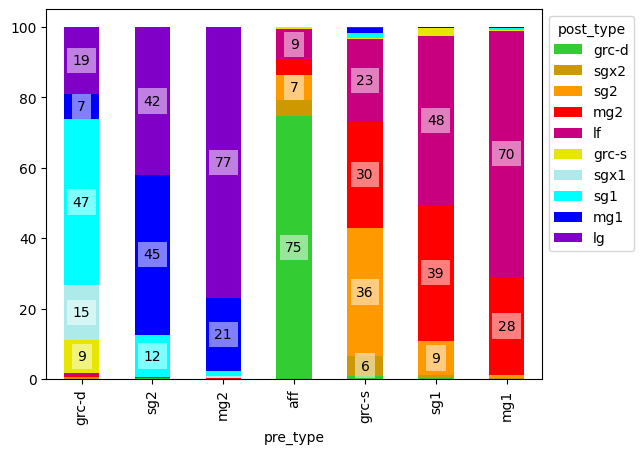

In [146]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = res.weight / syn_total *100

matrix_normalized = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0)


if syn == 'post-synaptic':
    order_pre = ['grc-d','sg2','mg2','aff','grc-s','sg1','mg1']#,'dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['grc-d','sgx2','sg2','mg2','lf','grc-s','sgx1','sg1','mg1','lg']#,'dml','tsd','uk','fov']
if syn == 'pre-synaptic':
    order_pre = ['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['aff','grc-d','sgx2','sg2','mg2','grc-s','sgx1','sg1','mg1']

ax = matrix_normalized.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

In [56]:
df_combined_col = deepcopy(matrix_normalized)
df_combined_col[columns_to_combine].sum(axis=1)
df_combined_col.loc[:,'focal types'] = df_combined_col[columns_to_combine].sum(axis=1)

In [58]:
df_combined_col.drop(columns=columns_to_combine)

post_type,dml,fov,tsd,uk,focal types
pre_type,,,,,
aff,0.0,4.0,0.0,13.0,83.0
dml,14.0,4.0,1.0,8.0,74.0
grc-d,1.0,7.0,18.0,10.0,64.0
grc-s,12.0,1.0,0.0,15.0,72.0
mg1,0.0,10.0,0.0,9.0,81.0
mg2,0.0,10.0,7.0,7.0,76.0
sg1,0.0,20.0,0.0,6.0,74.0
sg2,0.0,21.0,8.0,9.0,62.0


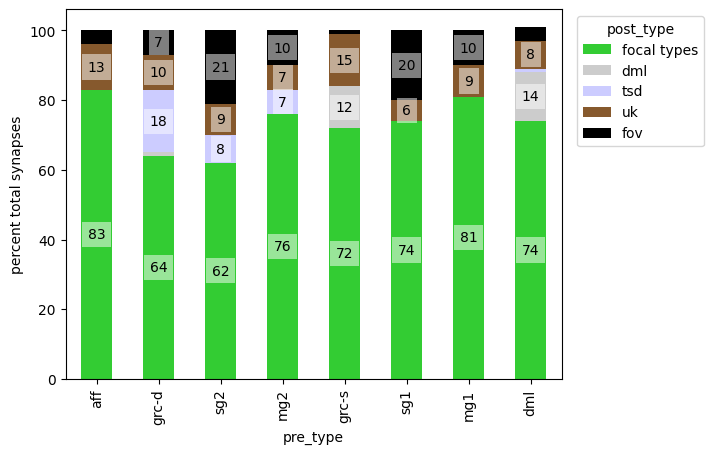

In [68]:
columns_to_combine=['grc-d', 'grc-s', 'lf', 'lg', 'mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2']
df_combined_col = deepcopy(matrix_normalized)
df_combined_col['focal types'] = df_combined_col[columns_to_combine].sum(axis=1)

# Drop the specified columns
df_combined_col.drop(columns=columns_to_combine,inplace=True)

order_pre = ['aff','grc-d','sg2','mg2','grc-s','sg1','mg1','dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
order_post = ['focal types','dml','tsd','uk','fov']

ax = df_combined_col.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylabel('percent total synapses');

In [43]:
matrix_normalized.index

Index(['aff', 'dml', 'grc-d', 'grc-s', 'mg1', 'mg2', 'sg1', 'sg2'], dtype='object', name='pre_type')

# cell variability among most completed

### bar

In [12]:

def typed_progress_df(df_edges,pre_type):

    res = df_edges[df_edges['pre_type'].isin(pre_type)].groupby(
        ['pre','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
    denom = res.groupby('pre')['weight'].sum()

    # res.weight = np.round(res.weight / denom *100)

    data = res.reset_index(level=[0,1]).fillna(0)
    
    return data

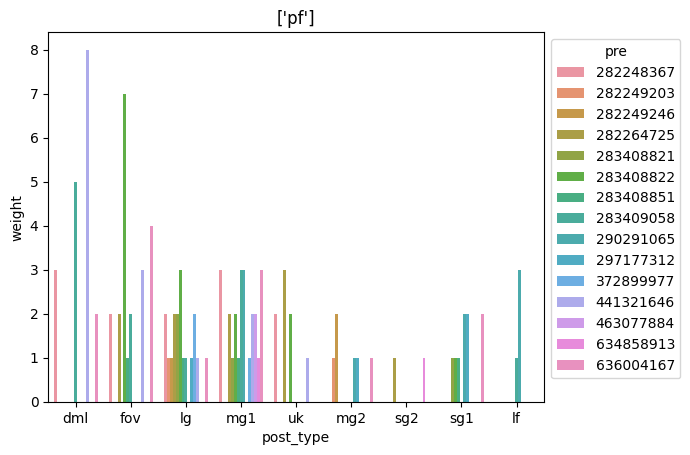

In [244]:
pre_type = ['pf']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
# ax = sns.barplot(data = df_edges[df_edges['pre_type'].isin(pre_type)], y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [221]:
data['pre'].unique()

array([290291065, 297177312, 372899977, 441321646, 463077884, 634858913,
       636004167])

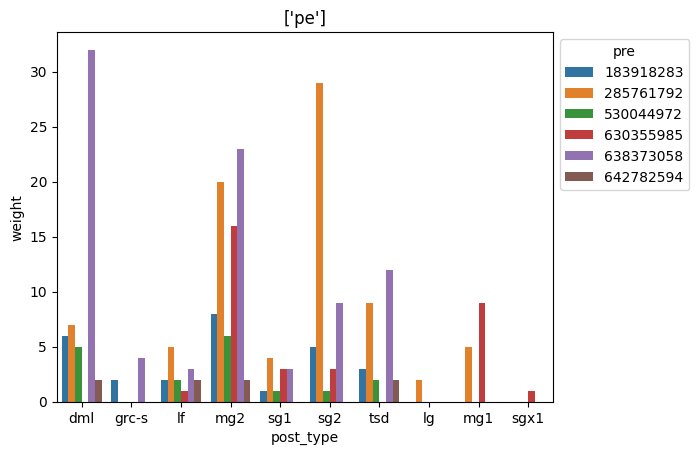

In [189]:
pre_type = ['pe']
data = typed_progress_df(df_edges,pre_type)
ax=sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

### heatmaps

In [112]:
types_ =  ['pf'] #df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    

    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

<AxesSubplot:xlabel='post_type', ylabel='pre'>

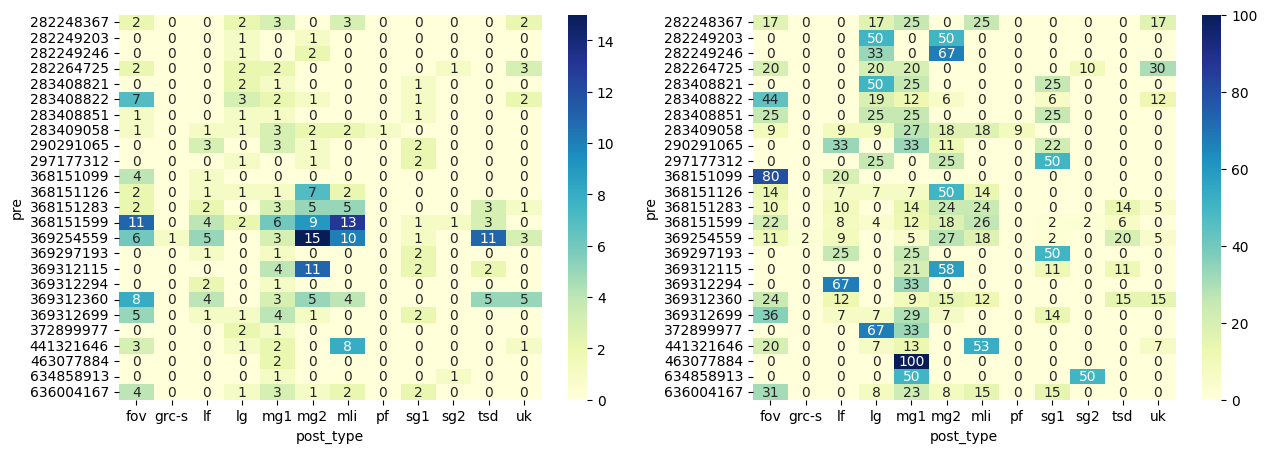

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(data=df_map, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])
sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

<AxesSubplot:xlabel='post_type', ylabel='pre'>

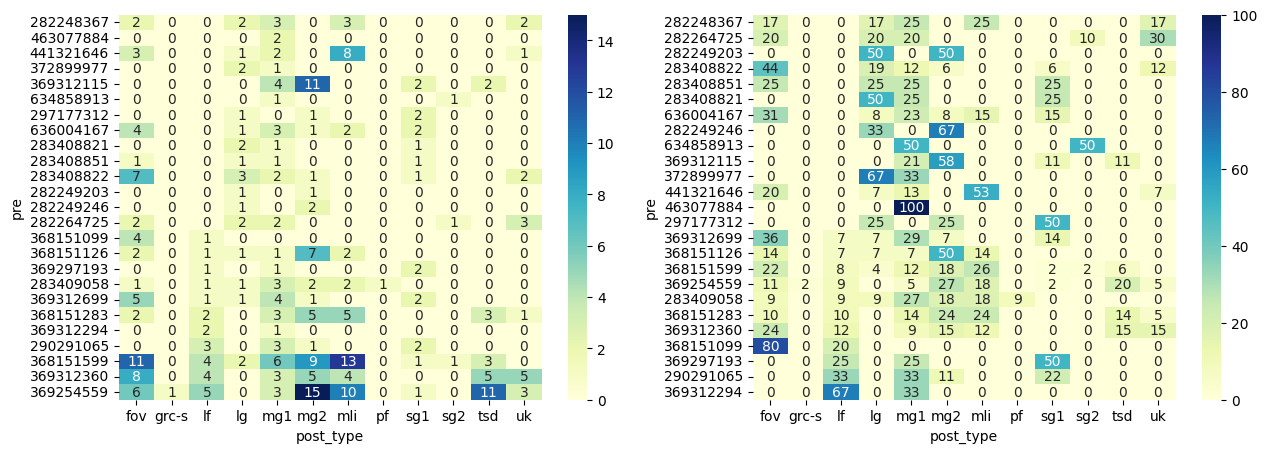

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_sorted = df_map.sort_values('lf')
sns.heatmap(data=df_sorted, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])
df_norm = df_sorted.div(df_sorted.sum(axis=1),axis=0).mul(100).round(0)
sns.heatmap(data=df_norm.sort_values('lf'), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

<AxesSubplot:xlabel='post_type', ylabel='pre'>

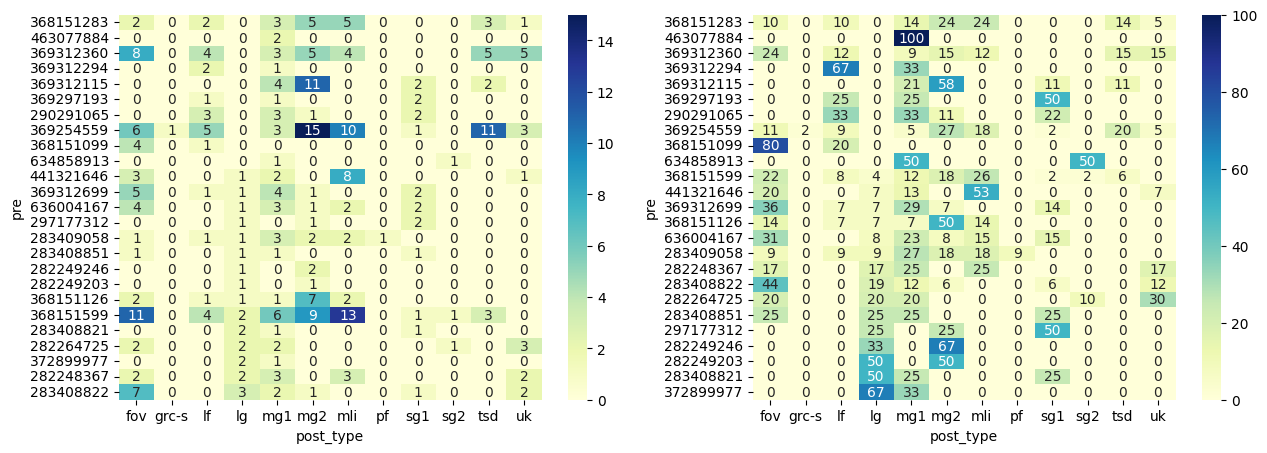

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_sorted = df_map.sort_values('lg')
sns.heatmap(data=df_sorted, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])
df_norm = df_sorted.div(df_sorted.sum(axis=1),axis=0).mul(100).round(0)
sns.heatmap(data=df_norm.sort_values('lg'), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

# cluster map

In [73]:
types_ =  ['pf']#df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    

    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')

In [74]:
tmp_type = pd.DataFrame(df_map['pre_type'])

In [75]:
df_map = df_map.drop(['pre_type'],axis=1)

# data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
data_df = df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0)
# data_df.loc[:,'pre_type']=tmp_type

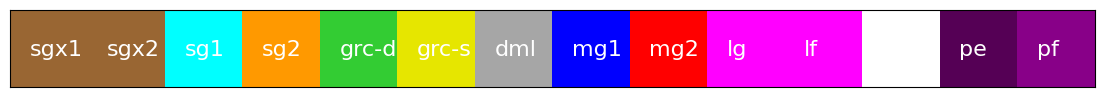

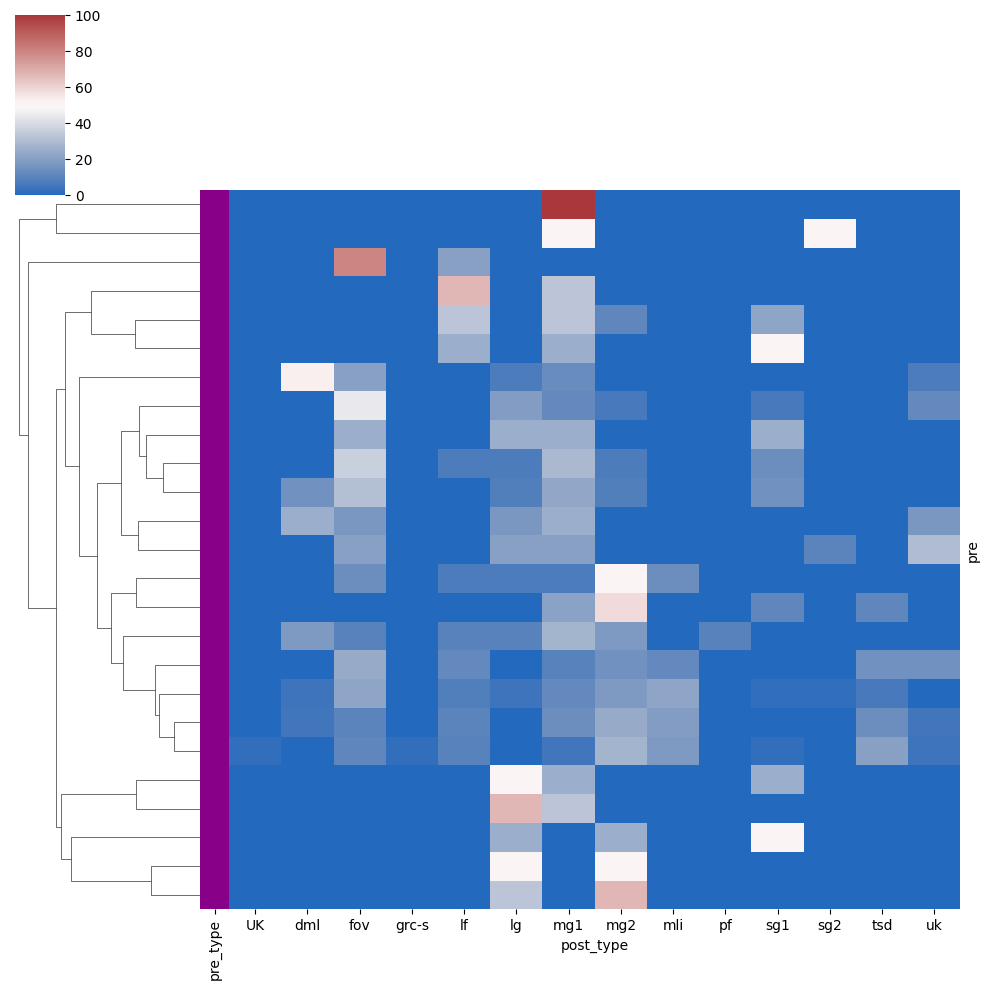

In [76]:
labels = tmp_type['pre_type'].unique()#df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))

color_dict = {
    'sgx1':'#996633',
    'sgx2':'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff',
    'pe':'#550055',
    'pf':'#880088'
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 


sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = tmp_type['pre_type'].map(color_dict));

# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap="YlGnBu", yticklabels=False,
#                row_colors = tmp_type['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

# Distribution of weights by type

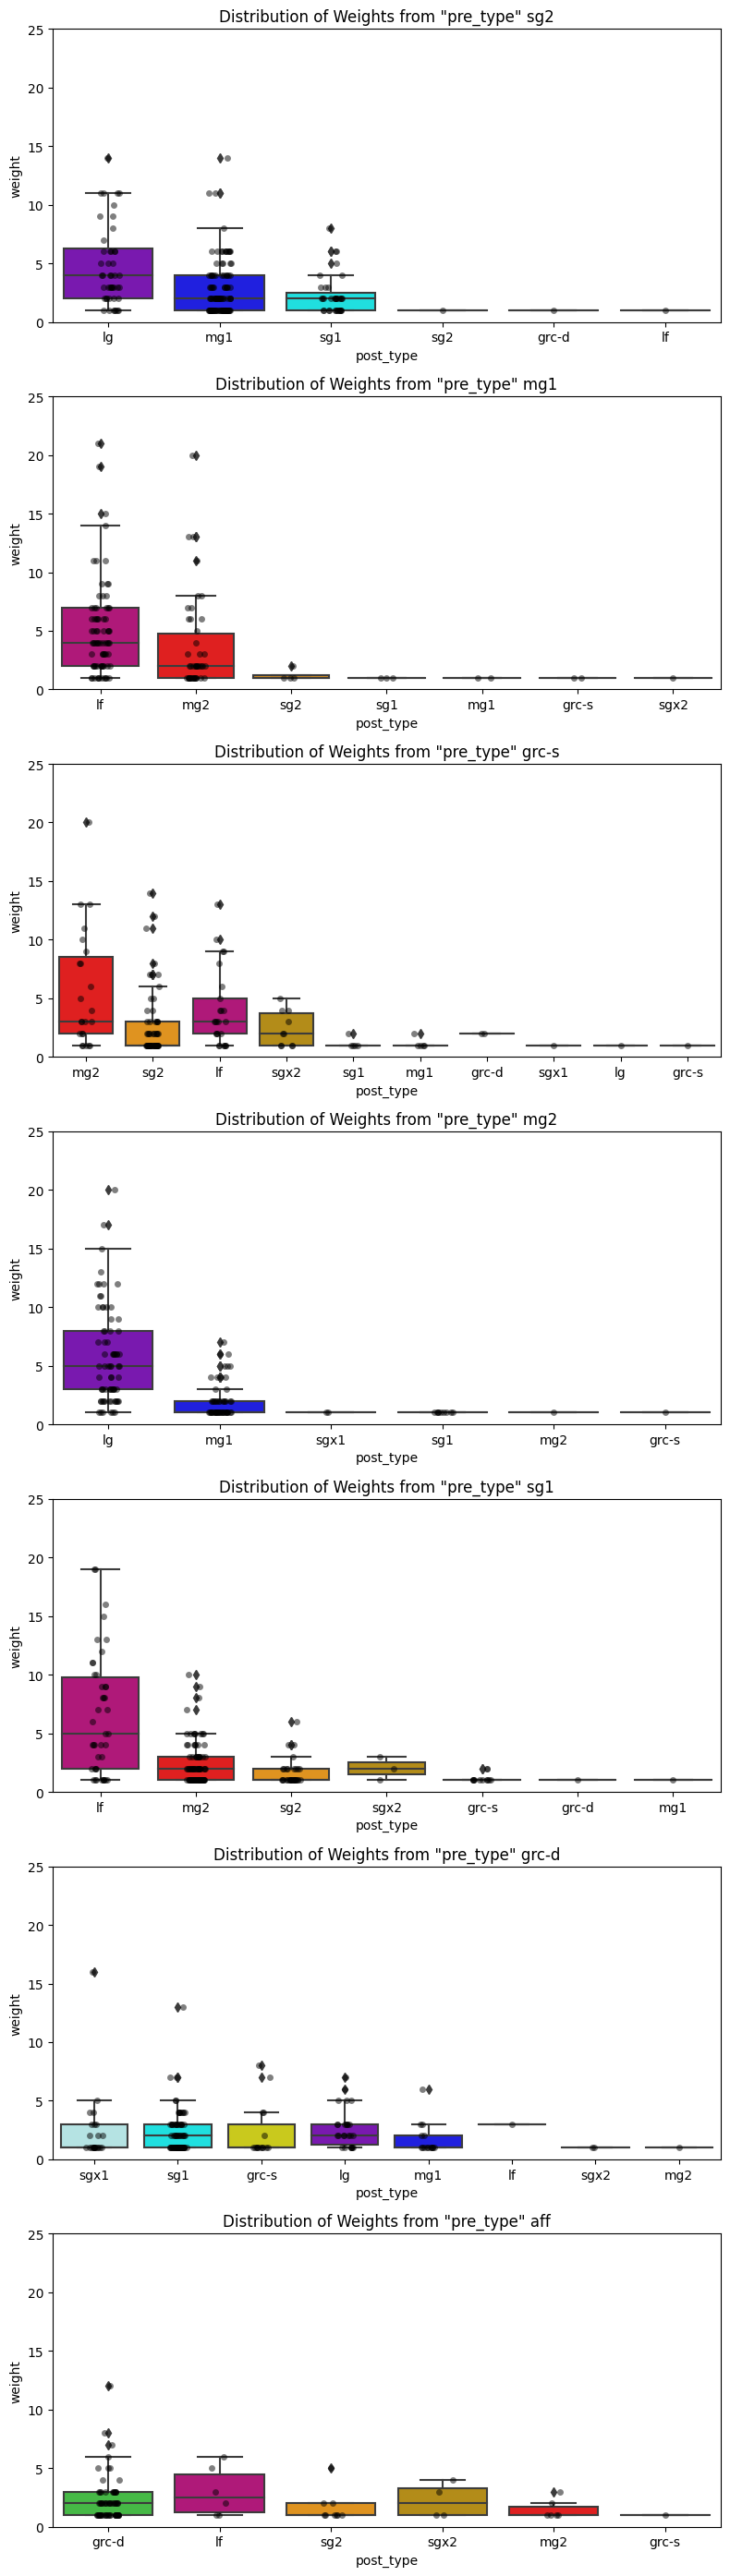

In [1833]:
# df= df_edges[(df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])) & (df_edges['post_type'].isin(['mg1','mg2','lf','lg']))]

fig, axes = plt.subplots(len(df_edges['pre_type'].unique()), 1, figsize=(8, 4 * len(df_edges['pre_type'].unique())))

for i,p in enumerate(df_edges['pre_type'].unique()):

    sns.boxplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],palette=syn_colors)#, inner='quartile', palette='Set2')
    sns.stripplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],color='black',alpha=0.5)
    axes[i].set_title(f'Distribution of Weights from "pre_type" {p}')
    axes[i].set_ylim(0,25)

plt.tight_layout()
plt.show()